In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Any, Dict, Optional, Callable
import torch.distributions as td
import numpy as np
import gym

In [2]:
from ezrl.optimizer import RLOptimizer
from ezrl.policy import GymPolicy
from ezrl.algorithms.reinforce import ReinforceOptimizer

In [3]:
class LunarLanderPolicy(GymPolicy):
    def __init__(self):
        super().__init__()
        self.input_dims = 8
        self.output_dims = 4

        self.net = nn.Sequential(
            nn.Linear(8, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 4, bias=False)
        )

    def forward(self, obs: Any) -> Dict[str, Any]:
        logits = self.net(obs)
        dist = td.Categorical(logits=logits)
        action = dist.sample()
        return {"action":action, "dist":dist}

    def act(self, obs: Any):
        out = self.forward(obs)
        return out["action"].item(), out

In [4]:
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime

def get_tensorboard_logger(experiment_name: str, base_log_path: str = "tensorboard_logs"):
    log_path = "{}/{}_{}".format(
            base_log_path, experiment_name, datetime.now()
        )
    train_writer = SummaryWriter(log_path, flush_secs=10)
    full_log_path = os.path.join(os.getcwd(), log_path)
    print(
        "Follow tensorboard logs with: tensorboard --logdir '{}'".format(
            full_log_path
        )
    )
    return train_writer

In [5]:
from tqdm import tqdm


policy = LunarLanderPolicy()
device = torch.device('cuda')
policy = policy.to(device)

In [6]:
policy.device

device(type='cuda', index=0)

In [7]:
def reinforce_rollout(
    policy: GymPolicy, env_name: str = None, env=None, env_creation_fn=None
):
    if env_name is None and env is None:
        raise ValueError("env_name or env must be provided!")
    if env is None:
        if env_creation_fn is None:
            env_creation_fn = gym.make
        env = env_creation_fn(env_name)
    done = False
    observations, actions, rewards = (
        [],
        [],
        [],
    )
    observation = env.reset()
    with torch.no_grad():
        while not done:
            action, out = policy.act(
                torch.from_numpy(observation).unsqueeze(0).to(policy.device)
            )
            next_observation, reward, done, info = env.step(action)

            observations.append(observation)
            actions.append(action)
            rewards.append(reward)

            observation = next_observation

    return np.array(observations), np.array(actions), np.array(rewards)


In [8]:
bar = tqdm(np.arange(1500))

writer = get_tensorboard_logger("ReinforceLunarLander")
optimizer = ReinforceOptimizer(policy, lr=0.001)

returns = []

for i in bar:
    observations, actions, rewards = optimizer.rollout(reinforce_rollout, env_name = "LunarLander-v2")

    torch_observations = torch.from_numpy(observations).to(policy.device)
    torch_actions = torch.from_numpy(actions).float().to(policy.device)
    torch_rewards = torch.from_numpy(rewards).float().to(policy.device)


    optimizer.zero_grad()
    loss = optimizer.loss_fn(torch_observations, torch_actions, torch_rewards)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    # metrics

    grad_dict = {}
    for n, W in policy.named_parameters():
        if W.grad is not None:
            grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

    loss = loss.item()
    sum_reward = np.sum(rewards)

    metrics_dict = {"loss":loss, "sum_reward":sum_reward, **grad_dict}

    for key in metrics_dict:
        writer.add_scalar(key, metrics_dict[key], i)

    returns.append(sum_reward)

    bar.set_description("Loss: {}, Reward: {}".format(loss, sum_reward))

  0%|                                                                          | 0/1500 [00:00<?, ?it/s]

Follow tensorboard logs with: tensorboard --logdir '/home/shyam/Code/ez-rl/examples/tensorboard_logs/ReinforceLunarLander_2022-12-07 13:29:32.181267'


Loss: -16.116268157958984, Reward: 9.406999535796182: 100%|█████████| 1500/1500 [19:39<00:00,  1.27it/s]


In [9]:
import time
def render(env: gym.Env, policy: GymPolicy):
    observation = env.reset()
    done = False
    rendereds = []
    rewards = []
    with torch.no_grad():
        while not done:
            rendered = env.render(mode="rgb_array")
            time.sleep(0.01)

            action, _ = policy.act(
                torch.from_numpy(observation).unsqueeze(0).to(policy.device)
            )
            next_observation, reward, done, _ = env.step(action)

            observation = next_observation

            rendereds.append(rendered)
            rewards.append(reward)
    env.close()
    return rendereds, rewards


In [10]:
env = gym.make("LunarLander-v2")
rendereds, rewards = render(env, policy)

In [11]:
np.sum(rewards)

109.41989405879352

In [15]:
import matplotlib.pyplot as plt

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [16]:
avg = movingaverage(returns, 10)

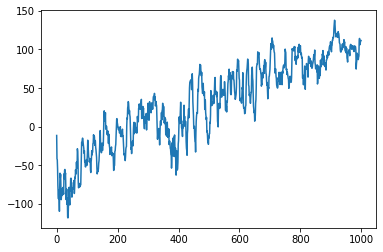

In [22]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis

ax.plot(avg[:1000] + 80)

In [23]:
fig.savefig("lunarlander-avg.png")

In [24]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib ipympl

plt.style.use('ggplot')
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from celluloid import Camera
from IPython.display import HTML


In [27]:
import time
def render(env: gym.Env, policy: GymPolicy):
    observation = env.reset()
    done = False
    rendereds = []
    rewards = []
    with torch.no_grad():
        while not done:
            rendered = env.render(mode="rgb_array")
            time.sleep(0.01)

            action, _ = policy.act(
                torch.from_numpy(observation).unsqueeze(0).to(policy.device)
            )
            next_observation, reward, done, _ = env.step(action)

            observation = next_observation

            rendereds.append(rendered)
            rewards.append(reward)
    env.close()
    return rendereds, rewards


In [38]:
def render_rollout():
    fig = plt.figure("Animation",figsize=(7,5))
    camera = Camera(fig)
    ax = fig.add_subplot(111)
    rendereds, rewards = render(env, policy)
    frames = []
    for r in rendereds:
        frame = ax.imshow(r)
        ax.axis('off')
        camera.snap()
        frames.append([frame])
    print("Sum Reward: {}".format(np.sum(rewards)))
    # animation = camera.animate(blit=False, interval=50)
    # display(animations.to_html5_video())
    return rewards, rendereds

In [40]:
rewards, rendereds = render_rollout()

Sum Reward: 128.15798271052444


In [43]:
from PIL import Image


In [44]:
imgs = [Image.fromarray(img) for img in rendereds]


In [48]:
imgs[0].save("LunarLander.mp4", save_all=True, append_images=imgs[1:], duration=1, loop=0)

ValueError: unknown file extension: .mp4

In [35]:
animation.save('LunarLander.gif')


KeyboardInterrupt

